In [28]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_113 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [33]:
import tensorflow as tf
import pandas as pd 
import re

dataset = pd.read_csv('../data/labeled_data.csv')

def process_tweets(df):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.

    Returns counts of urls, mentions, and hashtags.
    :return:
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = []

    for i in range(len(df)):
        text = df['tweet'][i]
        # 1) url
        text = re.sub(giant_url_regex, 'URLHERE', text)
        # 2) lots of whitespace
        text = re.sub(space_pattern, ' ', text)
        # 3) mentions
        text = re.sub(mention_regex, 'MENTIONHERE', text)
        # 4) hashtags
        text = re.sub(hashtag_regex, 'HASHTAGHERE', text)
        parsed_text.append(text)
    df['tweet'] = parsed_text
    return df

dataset = process_tweets(dataset)
dataset.head()


,id,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT MENTIONHERE: As a woman you shouldn't c...
1,1,3,0,3,0,1,!!!!! RT MENTIONHERE: boy dats cold...tyga dwn...
2,2,3,0,3,0,1,!!!!!!! RT MENTIONHERE Dawg!!!! RT MENTIONHERE...
3,3,3,0,2,1,1,!!!!!!!!! RT MENTIONHERE: MENTIONHERE she look...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT MENTIONHERE: The shit you hea...


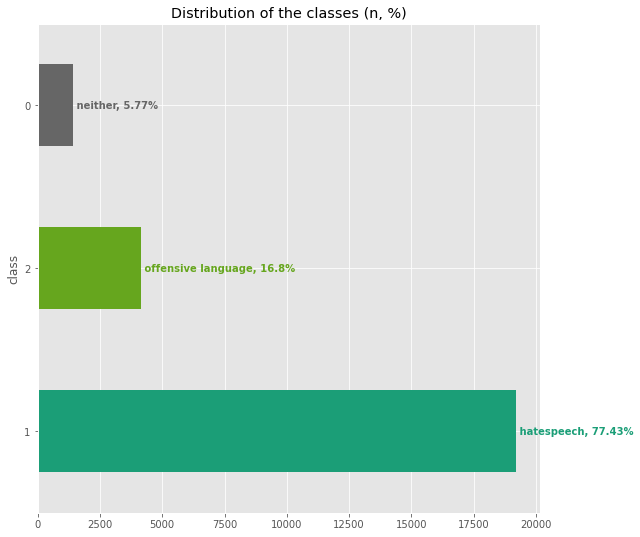

In [34]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')


num_classes = len(dataset["class"].value_counts())

colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
iter_color = iter(colors)

dataset['class'].value_counts().plot.barh(title="Distribution of the classes (n, %)", 
                                                 ylabel="class",
                                                 color=colors,
                                                 figsize=(9,9))

for i, v in enumerate(dataset['class'].value_counts()):
    c = next(iter_color)
    if i == 0:
      k = "hatespeech"
    elif i == 1:
        k = "offensive language"
    else:
        k = "neither"
    plt.text(v, i,
            " "+str(k)+", "+str(round(v*100/dataset.shape[0],2))+"%", 
            color=c, 
            va='center', 
            fontweight='bold')

In [35]:
dataset.drop(columns=['hate_speech','offensive_language','neither','count'], inplace=True)
#swap the columns tweet and class
dataset = dataset[['tweet','class']]
dataset.head()

,tweet,class
0,!!! RT MENTIONHERE: As a woman you shouldn't c...,2
1,!!!!! RT MENTIONHERE: boy dats cold...tyga dwn...,1
2,!!!!!!! RT MENTIONHERE Dawg!!!! RT MENTIONHERE...,1
3,!!!!!!!!! RT MENTIONHERE: MENTIONHERE she look...,1
4,!!!!!!!!!!!!! RT MENTIONHERE: The shit you hea...,1


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

y = tf.keras.utils.to_categorical(dataset["class"].values, num_classes=num_classes)

x_train, x_test, y_train, y_test = train_test_split(dataset['tweets'], y, test_size=0.25)